In [1]:
!pip install keras_preprocessing

import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras_preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


# Тестим наличие видиокарты
from tensorflow.python.client import device_lib
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(tf.config.experimental.get_memory_info("GPU:0")["current"])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0
1 Physical GPUs, 1 Logical GPUs


In [3]:
import pickle

with open('/kaggle/input/iz-3-data/200saved_state333.pickle', 'rb') as file:
    loaded_state = pickle.load(file)

abnormal_scans = loaded_state['abnormal_scans']
normal_scans = loaded_state['normal_scans']

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [4]:
import random
from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


print(tf.config.experimental.get_memory_info("GPU:0")["current"])
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))


batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x1 = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='same')(x1)
    x = layers.MaxPool3D(pool_size=2)(x)
    x2 = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='same')(x2)
    x = layers.MaxPool3D(pool_size=2)(x)
    x3 = layers.BatchNormalization()(x)

    x1_r = layers.MaxPool3D(pool_size=4)(x1)
    x2_r = layers.MaxPool3D(pool_size=2)(x2)
    x12 = layers.Concatenate(axis=4)([x1_r, x2_r])
    x123 = layers.Concatenate(axis=4)([x12, x3])
    x = layers.GlobalAveragePooling3D()(x123)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

0
Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 64, 64)     1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 64, 64, 32, 64)       0         ['conv3d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32, 64)       256       ['max_pooling3d[0][0]'] 

In [ ]:
# Показ снимков
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [5]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint("iz_3_image.h5", save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[
        checkpoint_cb,
    ],  # early_stopping_cb
)

print("End of Education")

Epoch 1/100
35/35 - 32s - loss: 0.7704 - acc: 0.5071 - val_loss: 0.6998 - val_acc: 0.5000 - 32s/epoch - 911ms/step
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 - 21s - loss: 0.7583 - acc: 0.4929 - val_loss: 0.7994 - val_acc: 0.5000 - 21s/epoch - 599ms/step
Epoch 3/100
35/35 - 21s - loss: 0.6837 - acc: 0.5714 - val_loss: 0.8258 - val_acc: 0.5000 - 21s/epoch - 602ms/step
Epoch 4/100
35/35 - 21s - loss: 0.6976 - acc: 0.5786 - val_loss: 0.8200 - val_acc: 0.5000 - 21s/epoch - 606ms/step
Epoch 5/100
35/35 - 21s - loss: 0.6431 - acc: 0.6214 - val_loss: 0.9365 - val_acc: 0.5000 - 21s/epoch - 599ms/step
Epoch 6/100
35/35 - 21s - loss: 0.6426 - acc: 0.5857 - val_loss: 0.9885 - val_acc: 0.5000 - 21s/epoch - 602ms/step
Epoch 7/100
35/35 - 21s - loss: 0.6508 - acc: 0.6000 - val_loss: 0.9515 - val_acc: 0.5000 - 21s/epoch - 603ms/step
Epoch 8/100
35/35 - 21s - loss: 0.6329 - acc: 0.6500 - val_loss: 1.1116 - val_acc: 0.5000 - 21s/epoch - 605ms/step
Epoch 9/100
35/35 - 21s - loss: 0.6124 - acc: 0.6500 - val_loss: 1.1682 - val_acc: 0.5000 - 21s/epoch - 600ms/step
Epoch 10/100
35/35 - 21s - loss: 0.5734 - acc: 0.7000 - val_loss: 1.3784 - val_acc: 0.5000 -

KeyboardInterrupt: 

1/1 [==============================] - 0s 359ms/step
This model is 32.59 percent confident that CT scan is normal
And this is 1
This model is 67.41 percent confident that CT scan is abnormal
And this is 1


/opt/conda/lib/python3.10/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (60, 128, 128, 64) (64 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/tmp/ipykernel_43/213256542.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


Accuracy: 0.6333333333333333
Precision: 0.6333333333333333
Recall: 0.6333333333333333


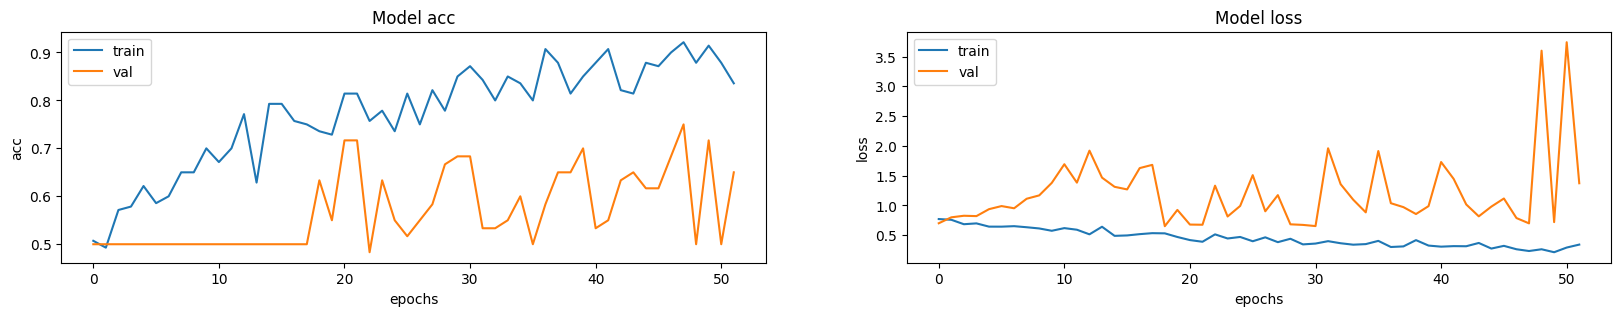

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Load best weights.
model.load_weights("iz_3_image.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
    print("And this is " + str(y_val[0]))


datagen = ImageDataGenerator()
generator = datagen.flow(x_val, batch_size=batch_size, shuffle=False)

y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


y_pred_binary = (y_pred > 0.5).astype(int)


# метрики
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


model.save("iz_3_image_save", save_format="tf")

plt.show()